### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as sw

import csv
import os
import pandas as pd

import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from scipy.fftpack import dct

### Constants

In [2]:
pre_emphasis = 0.97
frame_size = 0.02
frame_stride = 0.01
n_filt = 40
NFFT = 512
num_ceps = 12
cep_lifter = 22

### Extraction

In [3]:
def extract_feat(wavfile):
    sample_rate, signal = sw.read(wavfile)
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[: -1])
    
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate     # this converts from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # there might be samples left over

    pad_signal_length = num_frames * frame_step + frame_length    # get the total number needed
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    frames *= np.hamming(frame_length)
    
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))     # magnitude of the fast fourier transform
    pow_frames = (1.0 / NFFT) * ((mag_frames) ** 2)     # power spectrum
    
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate/2) / 700))    # mel frequency formular: converts Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filt + 2)       # equally spaced in the mel scale
    hz_points = (700 * (10 ** (mel_points / 2595) -1))      # convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((n_filt, int(np.floor(NFFT / 2 + 1))))

    for m in range(1, n_filt + 1):
        f_m_minus = int(bin[m-1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m+1])
    
        for k in range(f_m_minus, f_m):
            fbank[m-1, k] = (k - bin[m-1]) / (bin[m] - bin[m - 1])
        
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 0 : (num_ceps + 1)]       # keep coefficients 1-13
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

    mfcc = np.mean(mfcc.T, axis=1)
    
    return mfcc

In [4]:
with open('data/voice_wav.csv', 'w') as voice_wav:
    writer = csv.writer(voice_wav)
    writer.writerow(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13'])
    for filename in sorted(os.listdir('data/voice_wav')):
        if filename != '.DS_Store':
            writer.writerow(extract_feat('data/voice_wav/' + filename))

In [5]:
labels_df = pd.read_csv('data/accent_data.csv')
voice_freq_df = pd.read_csv('data/voice_wav.csv')

df = pd.concat([voice_freq_df, labels_df], axis=1, join='inner')

In [6]:
df.drop('id', inplace=True, axis=1)
df.to_csv('data/complete_accent_data.csv', index=False)

In [7]:
data = pd.read_csv('data/complete_accent_data.csv')

### Training

In [8]:
data.head(2)

f1          f2         f3         f4         f5         f6  \
0  401.239695  123.490505  12.157184  26.662176  29.153492 -84.712107   
1  373.922485   72.156262 -50.677178 -16.976158  14.355367 -70.798718   

           f7          f8         f9        f10   ...           f12  \
0   68.527963  -30.232709  66.032767  69.038635   ...      2.940817   
1  177.951314  107.191544  44.812517 -35.085892   ...    107.979801   

          f13  age  sex native_language residence birth_place father_tribe  \
0 -142.094611   27    f          yoruba      west        west       yoruba   
1 -131.383419   25    m          yoruba      west        west       yoruba   

  mother_tribe   tribe  
0       yoruba  yoruba  
1       yoruba  yoruba  

[2 rows x 21 columns]

### LabelEncoder for categorical variables

In [9]:
categorical_data = data.iloc[ :, :-1].values
label_encoder = LabelEncoder()
categorical_data[ : , 14] = label_encoder.fit_transform(categorical_data[ :, 14])
categorical_data[ : , 15] = label_encoder.fit_transform(categorical_data[ :, 15])
categorical_data[ : , 16] = label_encoder.fit_transform(categorical_data[ :, 16])
categorical_data[ : , 17] = label_encoder.fit_transform(categorical_data[ :, 17])
categorical_data[ : , 18] = label_encoder.fit_transform(categorical_data[ :, 18])
categorical_data[ : , 19] = label_encoder.fit_transform(categorical_data[ :, 19])

In [10]:
onehotencoder = OneHotEncoder(categorical_features=[14, 15, 16, 17, 18, 19])
categorical_data = onehotencoder.fit_transform(categorical_data)

In [11]:
dummy1 = pd.get_dummies(data['sex'])
dummy2 = pd.get_dummies(data['native_language'], prefix='native')
dummy3 = pd.get_dummies(data['residence'], prefix='residence')
dummy4 = pd.get_dummies(data['birth_place'], prefix='birth')
dummy5 = pd.get_dummies(data['father_tribe'], prefix='father')
dummy6 = pd.get_dummies(data['mother_tribe'], prefix='mother')

In [12]:
dataset = pd.concat([dummy1, dummy2, dummy3, dummy4, dummy5, dummy6, data], axis = 1)

In [13]:
dataset.drop(['sex', 'native_language', 'residence', 'birth_place', 'father_tribe', 'mother_tribe'], axis=1, inplace=True)

In [14]:
replacement = {"tribe": {'igbo':0, 'yoruba':1}}
dataset.replace(replacement, inplace=True)

In [15]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Training with SVM

In [17]:
#clf = SVC(C=20.0, gamma=0.00001, kernel='rbf')
clf = SVC(C=1.0, gamma=0.00001, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print(acc)
#print("acc=%0.3f" % acc)

0.9411764705882353


### Leave_One_Out Cross_Validation

In [18]:
def get_looc_value(model):
    loocv = sklearn.model_selection.LeaveOneOut()
    scores = cross_val_score(model, X, y, cv=loocv, scoring='accuracy')
    return scores.mean()

In [19]:
print(get_looc_value(clf))

0.9464285714285714


### SVM & Manual LOOC

In [20]:
def manual_looc(feature, label):

    count = 0
    predicted = []
    for i in range(len(feature)):
        current_test = feature.iloc[i]
        test_target = label.iloc[i]
        current_test = current_test.reshape(1, -1)
        
        index = list(range(0,i)) + list(range(i+1, len(feature)))
    
        train_target = label.iloc[index]
        current_train = feature.iloc[index]
    
        clf = SVC(C=1.0, gamma=0.00001, kernel='rbf')
        clf.fit(current_train, train_target)
        answer = clf.predict(current_test)
        predicted.append(answer)
        
        if (answer[0] == test_target):
            count = count + 1
    accuracy = (count / len(feature)) * 100
    return (accuracy, predicted)

In [21]:
A = dataset.iloc[:, :-1]       #.values
b = dataset.iloc[:, -1]        #.values

result = manual_looc(A, b)
print(result[0])

94.64285714285714


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


### Using KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

# Train the model using the training sets
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
knn_predicted = model.predict(X_test)
print(accuracy)

0.7058823529411765


In [23]:
print(get_looc_value(model))

0.8214285714285714


In [24]:
def manual_looc(feature, label):

    count = 0
    predicted = []
    for i in range(len(feature)):
        current_test = feature.iloc[i]
        test_target = label.iloc[i]
        current_test = current_test.reshape(1, -1)
        
        index = list(range(0,i)) + list(range(i+1, len(feature)))
    
        train_target = label.iloc[index]
        current_train = feature.iloc[index]
    
        model = KNeighborsClassifier(n_neighbors=4)
        model.fit(current_train, train_target)
        answer = model.predict(current_test)
        predicted.append(answer)
        
        if (answer[0] == test_target):
            count = count + 1
    accuracy = (count / len(feature)) * 100
    return (accuracy, predicted)
knn_result = manual_looc(A, b)
print(knn_result[0])

89.28571428571429


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


### Using Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
lr_predicted = model.predict(X_test)
print(accuracy)

0.8235294117647058


In [26]:
print(get_looc_value(model))

0.9107142857142857


### Confusion Matrix

In [27]:
def draw_conf(confusion_matrix, title):
    plt.clf()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Igbo','Yoruba']
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TI','FY'], ['FI', 'TY']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(confusion_matrix[i][j]))
    plt.show()

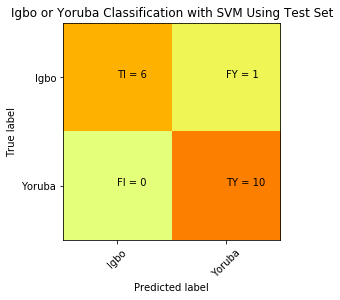

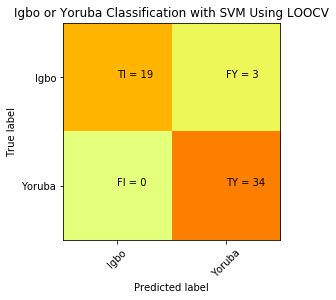

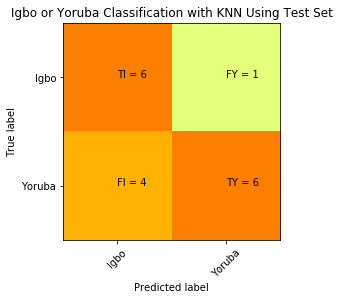

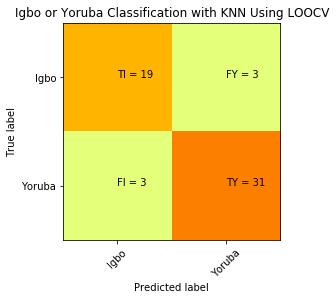

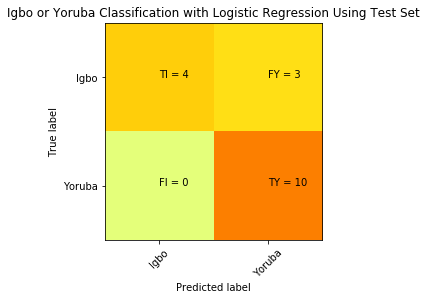

In [28]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_looc = confusion_matrix(y, result[1])

conf_mat_knn = confusion_matrix(y_test, knn_predicted)
conf_mat_knn_looc = confusion_matrix(y, knn_result[1])

conf_mat_lr = confusion_matrix(y_test, lr_predicted)

draw_conf(conf_mat, 'Igbo or Yoruba Classification with SVM Using Test Set')
draw_conf(conf_mat_looc, 'Igbo or Yoruba Classification with SVM Using LOOCV')


draw_conf(conf_mat_knn, 'Igbo or Yoruba Classification with KNN Using Test Set')
draw_conf(conf_mat_knn_looc, 'Igbo or Yoruba Classification with KNN Using LOOCV')


draw_conf(conf_mat_lr, 'Igbo or Yoruba Classification with Logistic Regression Using Test Set')

In [ ]:
# Grid search for best parameters
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5], 'C': [1, 10 ,20,30,40,50]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print('')
    
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print('')
    print(clf.best_params_)
    print('')
    print("Grid scores on development set:")
    print('')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('')
        
        print("Detailed classification report:")
        print('')
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print('')
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print('')